In [14]:
import torch_geometric
import networkx as nx
import numpy as np
import torch

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
dataset = PygLinkPropPredDataset(name = 'ogbl-ddi')
evaluator = Evaluator(name='ogbl-ddi')

split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]

PICKLE_PATH  = './latest_graph.pickle'
g  = nx.read_gpickle(PICKLE_PATH).to_undirected()

In [16]:
TRAIN_EDGE_NUM = train_edge['edge'].numpy().shape[0]

train_edge_total = train_edge['edge'].numpy()
np.random.shuffle(train_edge_total)
train_edge_pos = train_edge_total[:TRAIN_EDGE_NUM]

edge_index = torch_geometric.utils.convert.from_networkx(g).edge_index
num_edges = len(train_edge_pos)
train_edge_neg = negative_sampling(edge_index, num_nodes=len(g.nodes),
                                    num_neg_samples=TRAIN_EDGE_NUM, method='dense').numpy().T


In [17]:
train_edge_neg.shape, train_edge_pos.shape

((1067911, 2), (1067911, 2))

In [18]:
test_edge['edge'].numpy().shape, test_edge['edge_neg'].numpy().shape

((133489, 2), (95599, 2))

In [19]:
import pandas as pd
betw = nx.get_node_attributes(g,'betweenness')
eigc = nx.get_node_attributes(g,'eigenvect')
degc = nx.get_node_attributes(g,'degree_centr')
clust = nx.get_node_attributes(g,'clust')
node_to_neigh = {_node: set(g.neighbors(_node)) for _node in g.nodes()}


In [20]:
LABEL_COLUMN = 'edge_present'

def prepare_data_for_regression(pos_edges_numpy, neg_edges_numpy):
    _df_pos = pd.DataFrame(data=pos_edges_numpy, columns=['from','to'])
    _df_pos['edge_present'] = 1
    _df_neg = pd.DataFrame(data=neg_edges_numpy, columns=['from','to'])
    _df_neg['edge_present'] = 0
    _df = pd.concat([_df_pos,_df_neg])

    _df['neigh_from'] = _df['from'].map(node_to_neigh)
    _df['neigh_to'] = _df['to'].map(node_to_neigh)

    _df['common_neigh'] = _df.apply(lambda _row: len(list(_row['neigh_from'].intersection(_row['neigh_to']))), axis=1)
    _df['jaccard'] = _df.apply(lambda _row: _row['common_neigh']/len(list(_row['neigh_from'].union(_row['neigh_to']))), axis=1)
    _df['deg_from'] = _df['from'].map(g.degree)
    _df['deg_to'] = _df['to'].map(g.degree)
    _df['deg_min'] = _df[['deg_from','deg_to']].min(axis=1)
    _df['deg_max'] = _df[['deg_from','deg_to']].max(axis=1)

    _df['betw_from'] = _df['from'].map(betw)
    _df['betw_to'] = _df['to'].map(betw)
    _df['betw_min'] = _df[['betw_from','betw_to']].min(axis=1)
    _df['betw_max'] = _df[['betw_from','betw_to']].max(axis=1)

    _df['eigc_from'] = _df['from'].map(eigc)
    _df['eigc_to'] = _df['to'].map(eigc)
    _df['eigc_min'] = _df[['eigc_from','eigc_to']].min(axis=1)
    _df['eigc_max'] = _df[['eigc_from','eigc_to']].max(axis=1)

    _df['clust_from'] = _df['from'].map(clust)
    _df['clust_to'] = _df['to'].map(clust)
    _df['clust_min'] = _df[['clust_from','clust_to']].min(axis=1)
    _df['clust_max'] = _df[['clust_from','clust_to']].max(axis=1)

    _df.drop(columns=list(filter(lambda col: '_from' in col or '_to' in col, _df.columns)), inplace=True)
    _df.drop(columns=['from', 'to'], inplace=True)

    return _df


In [21]:
training_df = prepare_data_for_regression(train_edge_pos, train_edge_neg)
testing_df = prepare_data_for_regression(test_edge['edge'].numpy(), test_edge['edge_neg'].numpy())

In [32]:
get_nonlabel_columns = lambda _df: list(filter(lambda col: col != LABEL_COLUMN, _df.columns))

feats_train = training_df[get_nonlabel_columns(training_df)].to_numpy()
labels_train = training_df[LABEL_COLUMN].to_numpy()
clf = make_pipeline(StandardScaler(), LogisticRegression()).fit(feats_train, labels_train)

feats_test = testing_df[get_nonlabel_columns(testing_df)]
labels_test = testing_df[LABEL_COLUMN]

feats_pos = feats_test[labels_test == 1].to_numpy()
feats_neg = feats_test[labels_test == 0].to_numpy()

preds_pos_val = clf.predict_proba(feats_pos).max(axis=1)
preds_neg_val = clf.predict_proba(feats_neg).max(axis=1)

for K in [10, 20, 30]:
    evaluator.K = K
    valid_hits = evaluator.eval({
                'y_pred_pos': preds_pos_val,
                'y_pred_neg': preds_neg_val,
            })[f'hits@{K}']
    print("hits@{}: {:.5f}".format(K, valid_hits))

hits@10: 0.10650
hits@20: 0.10707
hits@30: 0.10959


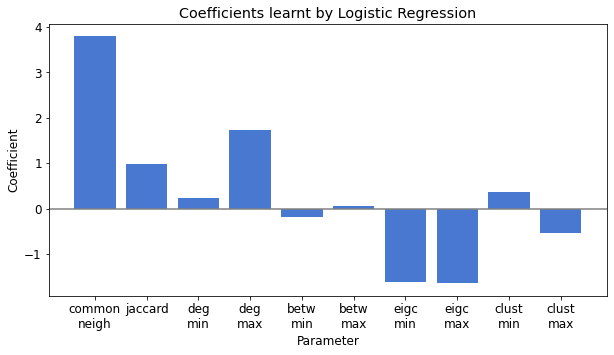

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import importlib
importlib.reload(plt)
importlib.reload(sns)
matplotlib.rcParams.update({'font.size': 12})

color = sns.color_palette("muted", as_cmap=True)
sns.set_palette(color)
fig = plt.figure(figsize=(10, 5))

plt.bar(list(map(lambda name: name.replace('_', '\n'),training_df[get_nonlabel_columns(training_df)].columns)), clf[1].coef_.flatten(), color=color[0])
plt.title("Coefficients learnt by Logistic Regression")
plt.axhline(y=0, color=".5")
plt.xlabel("Parameter")
plt.ylabel("Coefficient")
plt.savefig('logistic.pdf')

In [33]:
# Remove our top notch hardcrafted features

get_nonlabel_columns = lambda _df: list(filter(lambda col: col != LABEL_COLUMN and 'jaccard' not in col and 'common' not in col, _df.columns))

feats_train = training_df[get_nonlabel_columns(training_df)].to_numpy()
labels_train = training_df[LABEL_COLUMN].to_numpy()
clf = make_pipeline(StandardScaler(), LogisticRegression()).fit(feats_train, labels_train)

feats_test = testing_df[get_nonlabel_columns(testing_df)]
labels_test = testing_df[LABEL_COLUMN]

feats_pos = feats_test[labels_test == 1].to_numpy()
feats_neg = feats_test[labels_test == 0].to_numpy()

preds_pos_val = clf.predict_proba(feats_pos).max(axis=1)
preds_neg_val = clf.predict_proba(feats_neg).max(axis=1)

for K in [10, 20, 30]:
    evaluator.K = K
    valid_hits = evaluator.eval({
                'y_pred_pos': preds_pos_val,
                'y_pred_neg': preds_neg_val,
            })[f'hits@{K}']
    print("hits@{}: {:.5f}".format(K, valid_hits))

hits@10: 0.00016
hits@20: 0.00016
hits@30: 0.00025
